In [83]:
import pandas as pd
import requests, json

# API
city_name = 'Melbourne'
API_KEY = '6456aee2ec2d47df861f5e544387a73c'
lat = -37.810236
lon = 144.962765

complete_url = f"https://pro.openweathermap.org/data/2.5/forecast/hourly?lat={lat}&lon={lon}&appid={API_KEY}"

melbourne_tz = pytz.timezone("Australia/Melbourne")
start_time = melbourne_tz.localize(datetime(2024, 10, 26, 0, 0))
end_time = melbourne_tz.localize(datetime(2024, 11, 1, 1, 0))

def convert_to_utc(date):
    utc_date = date.astimezone(pytz.utc)
    utc_timestamp = int(utc_date.timestamp())
    return utc_timestamp

start_time = convert_to_utc(start_time)
end_time = convert_to_utc(end_time)

start = 1609459200
end = 1609545600

load_url = f"https://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start_time}&end={end_time}&appid={API_KEY}"

response = requests.get(complete_url)

history_data = requests.get(load_url)

x = response.json()
history = history_data.json()

<AxesSubplot: xlabel='datetime_melbourne'>

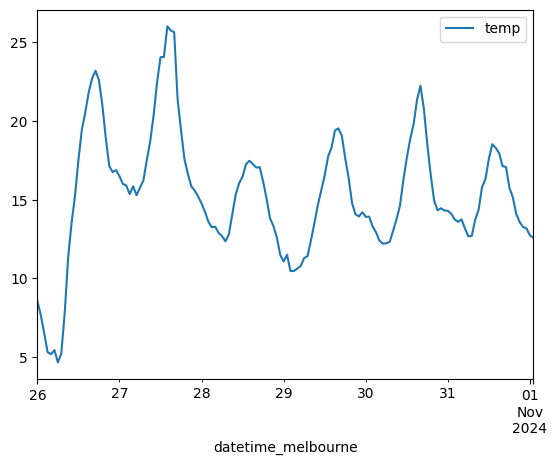

In [93]:
hist_df = pd.DataFrame(history['list'])

melbourne_tz = pytz.timezone("Australia/Melbourne")
hist_df['datetime_melbourne'] = hist_df['dt'].apply(
    lambda x: pytz.utc.localize(datetime.utcfromtimestamp(x)).astimezone(melbourne_tz)
)
hist_df['temp'] = hist_df['main'].apply(lambda x: x['temp'] - 273.15)  # Convert Kelvin to Celsius


hist_df[['datetime_melbourne', 'temp']].tail(10)

# Look for index where temp is 20.4
#hist_df[hist_df['temp'] == 12.75]

# Plot the temp
hist_df.plot(x='datetime_melbourne', y='temp', kind='line')

<AxesSubplot: >

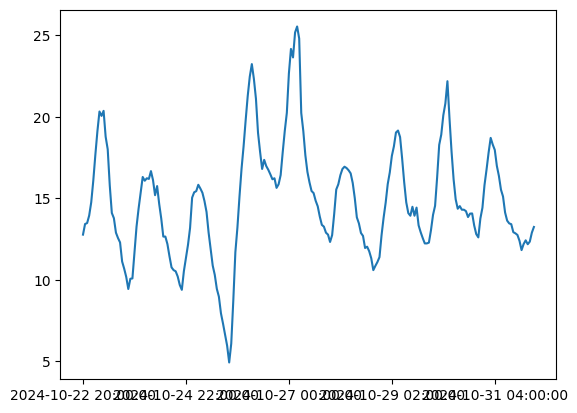

In [ ]:
# Load Novemebr Data
import pandas as pd
pedestriants = pd.read_csv('..\\data\\processed\\final_df.csv', index_col=0)

# Plot the last 5 days
pedestriants['temp'].tail(220).plot()


The data do not match 100 % why?

In [95]:
hist_df[['datetime_melbourne','temp']]

,datetime_melbourne,temp
0,2024-10-26 00:00:00+11:00,8.55
1,2024-10-26 01:00:00+11:00,7.67
2,2024-10-26 02:00:00+11:00,6.52
3,2024-10-26 03:00:00+11:00,5.31
4,2024-10-26 04:00:00+11:00,5.18
...,...,...
141,2024-10-31 21:00:00+11:00,13.58
142,2024-10-31 22:00:00+11:00,13.26
143,2024-10-31 23:00:00+11:00,13.17
144,2024-11-01 00:00:00+11:00,12.73


In [90]:
pedestriants_nov = pd.read_csv('..\\data\\raw\\November_2024.csv', index_col=0)
past_ped = pedestriants_nov[['Hour','Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)']]
past_ped

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South)
Date,,,,,,
01/11/2024,0,177,9,494,814,478
01/11/2024,1,126,11,278,467,334
01/11/2024,2,81,1,192,224,238
01/11/2024,3,55,2,96,113,190
01/11/2024,4,54,12,84,77,133
...,...,...,...,...,...,...
30/11/2024,19,1038,602,2079,961,998
30/11/2024,20,1145,559,1857,971,973
30/11/2024,21,1280,503,1965,783,1015


## Converting to used format for model

In [14]:
from datetime import datetime
import pytz
import pandas as pd


df = pd.DataFrame(x['list'])
df

# Extract relevant columns
df['temp'] = df['main'].apply(lambda x: x['temp'] - 273.15)  # Convert Kelvin to Celsius
df['humidity'] = df['main'].apply(lambda x: x['humidity'])
# replace NAn with 0 in df['rain']
df['rain'] = df['rain'].fillna(0)
df['clouds'] = df['clouds'].apply(lambda x: x['all'])

# Convert Unix timestamp to Melbourne local time
melbourne_tz = pytz.timezone("Australia/Melbourne")
df['datetime_melbourne'] = df['dt'].apply(
    lambda x: pytz.utc.localize(datetime.utcfromtimestamp(x)).astimezone(melbourne_tz)
)

# Set datetime as index
df.set_index('datetime_melbourne', inplace=True)

# Keep only relevant columns
df = df[['temp', 'humidity', 'rain', 'clouds']]

# Display the table
df.head(2)

,temp,humidity,rain,clouds
datetime_melbourne,,,,
2024-12-05 05:00:00+11:00,13.96,80,0,0
2024-12-05 06:00:00+11:00,14.04,78,0,0


In [15]:
import holidays

# Create a list of public holidays in Victoria
australia_holidays = holidays.Australia(state='VIC')

# Add a new column to indicate whether each date is a public holiday
df['IsPublicHoliday'] = [
    1 if date in australia_holidays else 0 for date in df.index.date
]

df['Hour'] = df.index.hour
df['Weekday'] = df.index.weekday + 1
df['Month'] = df.index.month
df['Season'] = df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                      3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                      6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                      9: 'Fall', 10: 'Fall', 11: 'Fall'})

# Display the updated DataFrame
df.head(3)

,temp,humidity,rain,clouds,IsPublicHoliday,Hour,Weekday,Month,Season
datetime_melbourne,,,,,,,,,
2024-12-05 05:00:00+11:00,13.96,80,0,0,0,5,4,12,Winter
2024-12-05 06:00:00+11:00,14.04,78,0,0,0,6,4,12,Winter
2024-12-05 07:00:00+11:00,14.68,72,0,0,0,7,4,12,Winter


In [16]:
categorical_columns = ['Weekday', 'Month', 'Season']

# Dummy-encode all categorical columns
df_with_all_dummies = pd.get_dummies(df, columns=categorical_columns)

df_with_all_dummies.columns

Index(['temp', 'humidity', 'rain', 'clouds', 'IsPublicHoliday', 'Hour',
       'Weekday_1', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7',
       'Month_12', 'Season_Winter'],
      dtype='object')

In [ ]:
old_columns = ['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
        'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter']

reordered_df = df_with_all_dummies.reindex(columns=old_columns, fill_value=0)
reordered_df.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

# When Creating dummies they need to match the reference groups of the models and the coloumns too